# Lyrics genre single label classification

This notebook:
* Uses the dataset generated by **helgi-05-scraped-lyrics-v2-preprocessing.ipynb**
* Performs **single** label classification on the genres available

In [1]:
import random
import ast

import numpy as np
import pandas as pd

random_state = 1111
np.random.seed(random_state)
random.seed(random_state)

import sklearn.multiclass
import sklearn.linear_model
import sklearn.naive_bayes
import sklearn.utils

import seaborn as sns
from matplotlib import pyplot as plt

import sys
sys.path.append("../")

from libs.processing import (
    Lemmatizer,
    Stemmer,
    StopWords,
    fit_vectorizer,
    random_search,
    choose_random_params
)

E:\Repos\comp550-final-project\venv\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


## Load and prepare data

In [2]:
df = pd.read_csv('E:\\Repos\\comp550-final-project\\data\\scraped-lyrics-v2-preprocessed.csv')
df

,artist,song,lyrics,genres,category
0,12 Stones,3 Leaf Loser,"Biting the hand that feeds you, lying to the v...","['Hard Rock', 'Rock']",Hard Rock
1,12 Stones,Adrenaline,My heart is beating faster can't control these...,"['Hard Rock', 'Rock']",Hard Rock
2,12 Stones,Anthem For The Underdog,You say you know just who I am\nBut you can't ...,"['Hard Rock', 'Rock']",Hard Rock
3,12 Stones,Anthem For The Underdog (Picture Perfect Sessi...,You say you know just who I am\nBut you can't ...,"['Hard Rock', 'Rock']",Hard Rock
4,12 Stones,Arms Of A Stranger,"I came home early to see you,\nCouldn't wait t...","['Hard Rock', 'Rock']",Hard Rock
...,...,...,...,...,...
58714,Ängie,Spun,"Avoid eye contact, you want it, I know it's a ...",['Indie'],Indie
58715,Ängie,Talk to Me Nice,Imma fuck you up\nImma fuck you up\nImma fuck ...,['Indie'],Indie
58716,Ängie,Two Together,I don't even think that you're my type\nYou're...,['Indie'],Indie
58717,Ängie,Venus In Furs,"Shiny, shiny, shiny boots of leather\nWhiplash...",['Indie'],Indie


In [3]:
# genres are a string, let's convert to a list
df.genres = df.genres.apply(lambda x: ast.literal_eval(x))

In [4]:
data_ratio = 1 # How much of the data to use
df.index.to_numpy()
splits = [0.7, 0.85]

indices = sklearn.utils.shuffle(df.index.to_numpy(), random_state=1234)
n_data_used = int(data_ratio*len(indices))

all_data = []
for i in indices[ : n_data_used]:
    song = df.iloc[i]
    all_data.append((song.lyrics, song.category))

all_data = np.array(all_data, dtype=object)
n = len(all_data)
data = {
    'X_train_raw': all_data[:int(splits[0]*n), 0],
    'y_train': all_data[:int(splits[0]*n), 1],
    'X_valid_raw': all_data[int(splits[0]*n):int(splits[1]*n), 0],
    'y_valid': all_data[int(splits[0]*n): int(splits[1]*n), 1],
    'X_test_raw': all_data[int(splits[1]*n):, 0],
    'y_test': all_data[int(splits[1]*n):, 1]
}

print(f'Ratio of data used: {data_ratio}*{len(indices)} = {n_data_used}')

Ratio of data used: 1*58719 = 58719


## Validation set hyper-parameter search across models

In [5]:
search_params = {
    'data': {
        'tokenizer': [Lemmatizer, Stemmer],
        'stop_words': [StopWords('nltk_english'), StopWords('None', [])],
        'min_df': [0, 1, 2, 3] # Minimum token frequency
    },
    'model': {
        'logistic_regression': {
            'eta0': [1e-3, 1e-2, 1e-1], # learning rate
            'alpha': [1e-3, 1e-2, 1e-1], # regularization
            'max_iter': np.arange(start=1, stop=10), # epochs
            'loss': ['log'],
            'random_state': [random_state]
        },
        'naive_bayes': {
            'alpha': np.arange(start=0.1, stop=1.1, step=0.1)
        },
        'random_forest': {
            'n_estimators': np.arange(start=10, stop=1000, step=10),
            'max_depth': np.arange(start=1, stop=10, step=2),
            'random_state': [random_state]
        }
    }
}

models = {
    'logistic_regression': sklearn.linear_model.SGDClassifier,
    'naive_bayes': sklearn.naive_bayes.MultinomialNB,
    'random_forest': sklearn.ensemble.RandomForestClassifier
}

In [6]:
data_sets, results = random_search(models, data, search_params, n_datasets=4, n_models=4, multi_label=False)

Data set variation 1/4
	Fitting vectorizer...
	logistic_regression 1/4
	logistic_regression 2/4
	logistic_regression 3/4
	logistic_regression 4/4
	naive_bayes 1/4
	naive_bayes 2/4
	naive_bayes 3/4
	naive_bayes 4/4
	random_forest 1/4
	random_forest 2/4
	random_forest 3/4
	random_forest 4/4
Data set variation 2/4
	Fitting vectorizer...
	logistic_regression 1/4
	logistic_regression 2/4
	logistic_regression 3/4
	logistic_regression 4/4
	naive_bayes 1/4
	naive_bayes 2/4
	naive_bayes 3/4
	naive_bayes 4/4
	random_forest 1/4
	random_forest 2/4
	random_forest 3/4
	random_forest 4/4
Data set variation 3/4
	Fitting vectorizer...
	logistic_regression 1/4
	logistic_regression 2/4
	logistic_regression 3/4
	logistic_regression 4/4
	naive_bayes 1/4
	naive_bayes 2/4
	naive_bayes 3/4
	naive_bayes 4/4
	random_forest 1/4
	random_forest 2/4
	random_forest 3/4
	random_forest 4/4
Data set variation 4/4
	Fitting vectorizer...
	logistic_regression 1/4
	logistic_regression 2/4
	logistic_regression 3/4
	logistic

In [7]:
for i, params in enumerate(data_sets):
    params_str = {key: str(param) for key, param in params.items()}
    print(f'\nDataset variation {i+1}: {params_str}')
    model_results = results[i]
    for model_name, params in model_results.items():
        print(f'\t{model_name}:')
        for j in range(len(params)):
            print('\t\t{}'.format({
                    'model_params': params[j]['model_params'],
                    'valid_accuracy': params[j]['valid_accuracy']
            }))



Dataset variation 1: {'tokenizer': "<class 'libs.processing.Lemmatizer'>", 'stop_words': 'None', 'min_df': '1'}
	logistic_regression:
		{'model_params': {'eta0': 0.001, 'alpha': 0.1, 'max_iter': 3, 'loss': 'log', 'random_state': 1111}, 'valid_accuracy': 0.36830154405086285}
		{'model_params': {'eta0': 0.1, 'alpha': 0.001, 'max_iter': 4, 'loss': 'log', 'random_state': 1111}, 'valid_accuracy': 0.35240690281562215}
		{'model_params': {'eta0': 0.1, 'alpha': 0.001, 'max_iter': 5, 'loss': 'log', 'random_state': 1111}, 'valid_accuracy': 0.33060853769300635}
		{'model_params': {'eta0': 0.01, 'alpha': 0.001, 'max_iter': 8, 'loss': 'log', 'random_state': 1111}, 'valid_accuracy': 0.35603996366939145}
	naive_bayes:
		{'model_params': {'alpha': 0.30000000000000004}, 'valid_accuracy': 0.4257493188010899}
		{'model_params': {'alpha': 0.1}, 'valid_accuracy': 0.430063578564941}
		{'model_params': {'alpha': 0.5}, 'valid_accuracy': 0.4264305177111717}
		{'model_params': {'alpha': 0.9}, 'valid_accuracy':

## Test set results

In [8]:
best_models = {
    'logistic_regression': 3,
    'naive_bayes': 0,
    'random_forest': 3
}

for model_name, model_index in best_models.items():
    print(f'Best {model_name} test sets accuracies:')
    for i in range(len(results)):
        print(f'\tDataset {i+1}: {results[i][model_name][model_index]["test_accuracy"]:.3f}')

random_predictions = np.random.choice(df.category.unique(), size=data['y_test'].shape[0])
random_accuracy = sklearn.metrics.accuracy_score(data['y_test'], random_predictions)
print(f'Random classifier test set accuracy: {random_accuracy:.3f}', end='\n\n')

Best logistic_regression test sets accuracies:
	Dataset 1: 0.356
	Dataset 2: 0.392
	Dataset 3: 0.393
	Dataset 4: 0.360
Best naive_bayes test sets accuracies:
	Dataset 1: 0.422
	Dataset 2: 0.426
	Dataset 3: 0.426
	Dataset 4: 0.420
Best random_forest test sets accuracies:
	Dataset 1: 0.268
	Dataset 2: 0.269
	Dataset 3: 0.259
	Dataset 4: 0.287
Random classifier test set accuracy: 0.094



Best model (Naive Bayes) confusion matrix:


<AxesSubplot:>

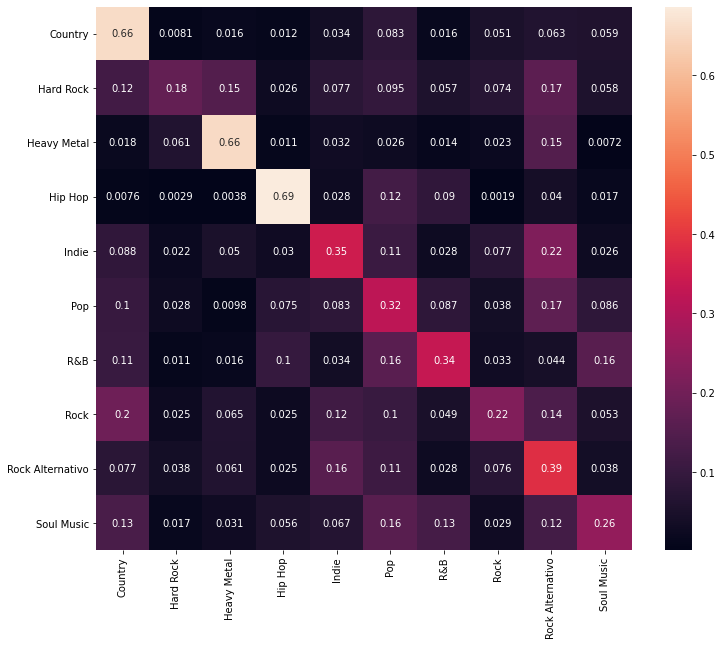

In [11]:
print('Best model (Naive Bayes) confusion matrix:')
confusion_matrix = results[0]['naive_bayes'][0]['df_test_confusion_matrix']
plt.figure(figsize = (12,10))
plt.xticks(rotation=90)
sns.heatmap(confusion_matrix, annot=True)